In [19]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import os
from tensorflow.keras.layers import LeakyReLU

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
Device: 
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:T

Train set:
PNEUMONIA=3875
NORMAL=3875
Test set:
PNEUMONIA=390
NORMAL=234


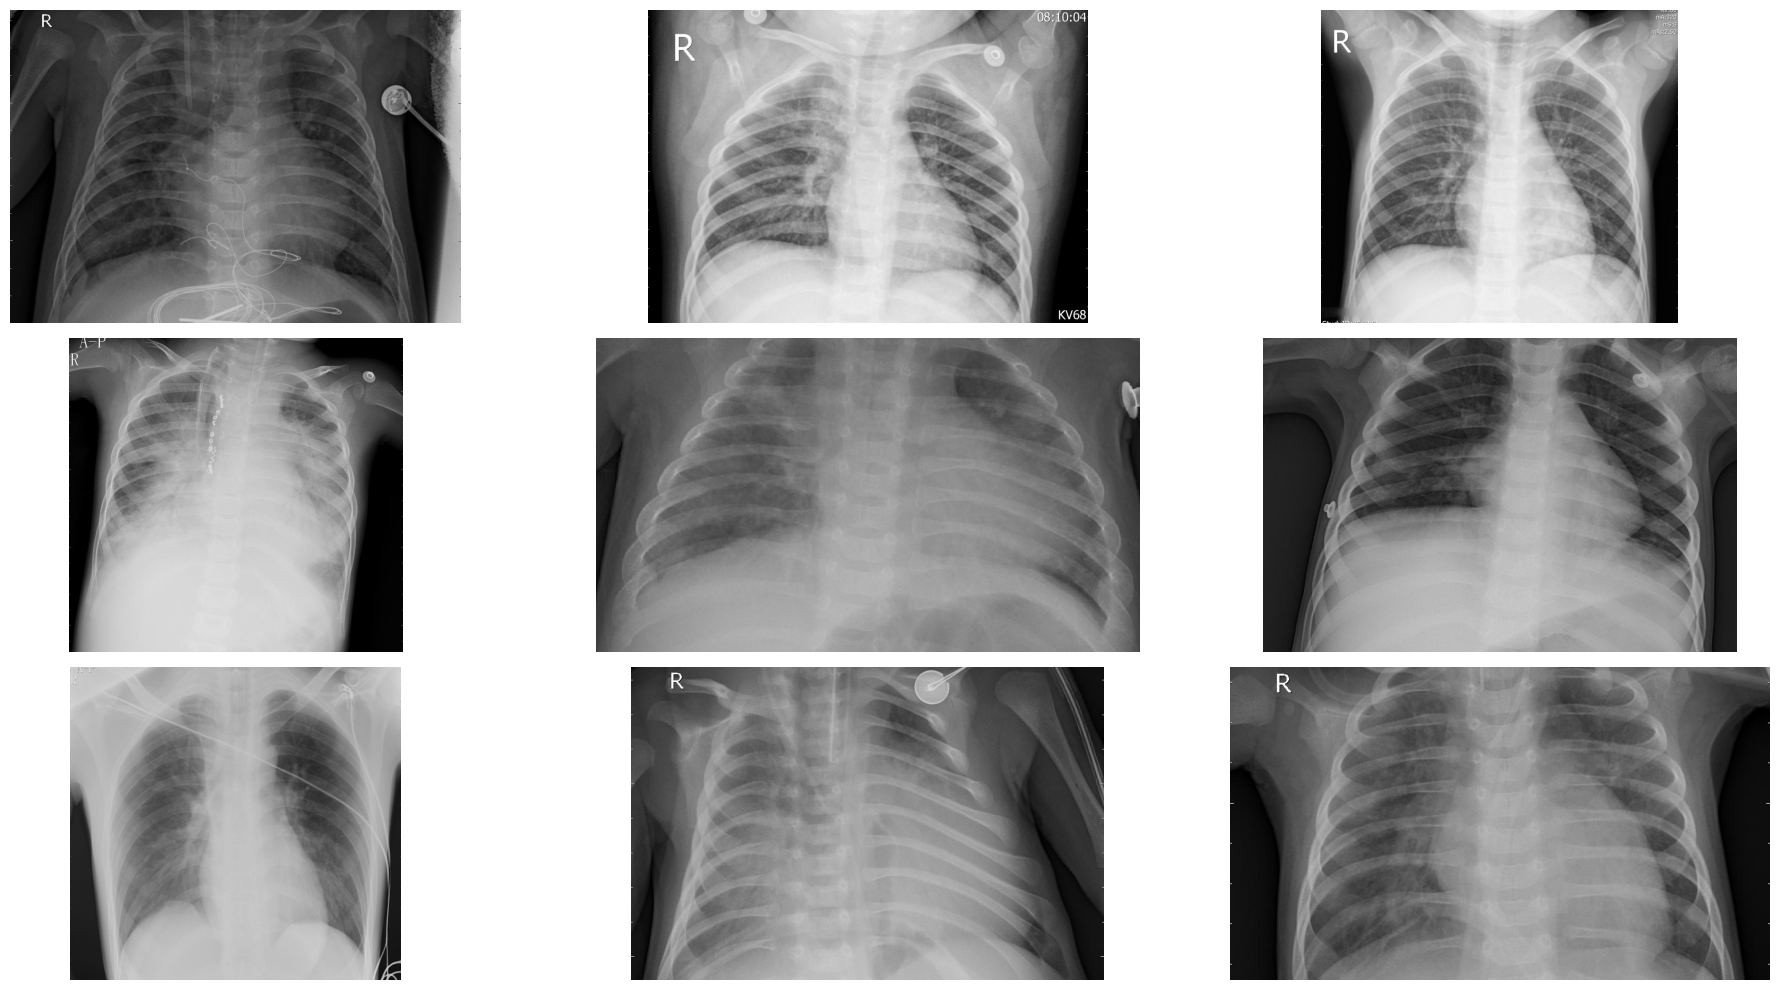

In [3]:
ds = '/kaggle/input/test-xray'
train_dir = f"{ds}/chest_xray/train"
# val_dir = f"{ds}/chest_xray/val"
test_dir = f"{ds}/chest_xray/test"

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

# print("Val set:\n========================================")
# num_pneumonia = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
# num_normal = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
# print(f"PNEUMONIA={num_pneumonia}")
# print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

pneumonia = os.listdir("/kaggle/input/test-xray-gen/chest_xray/train/PNEUMONIA")
pneumonia_dir = "/kaggle/input/test-xray-gen/chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

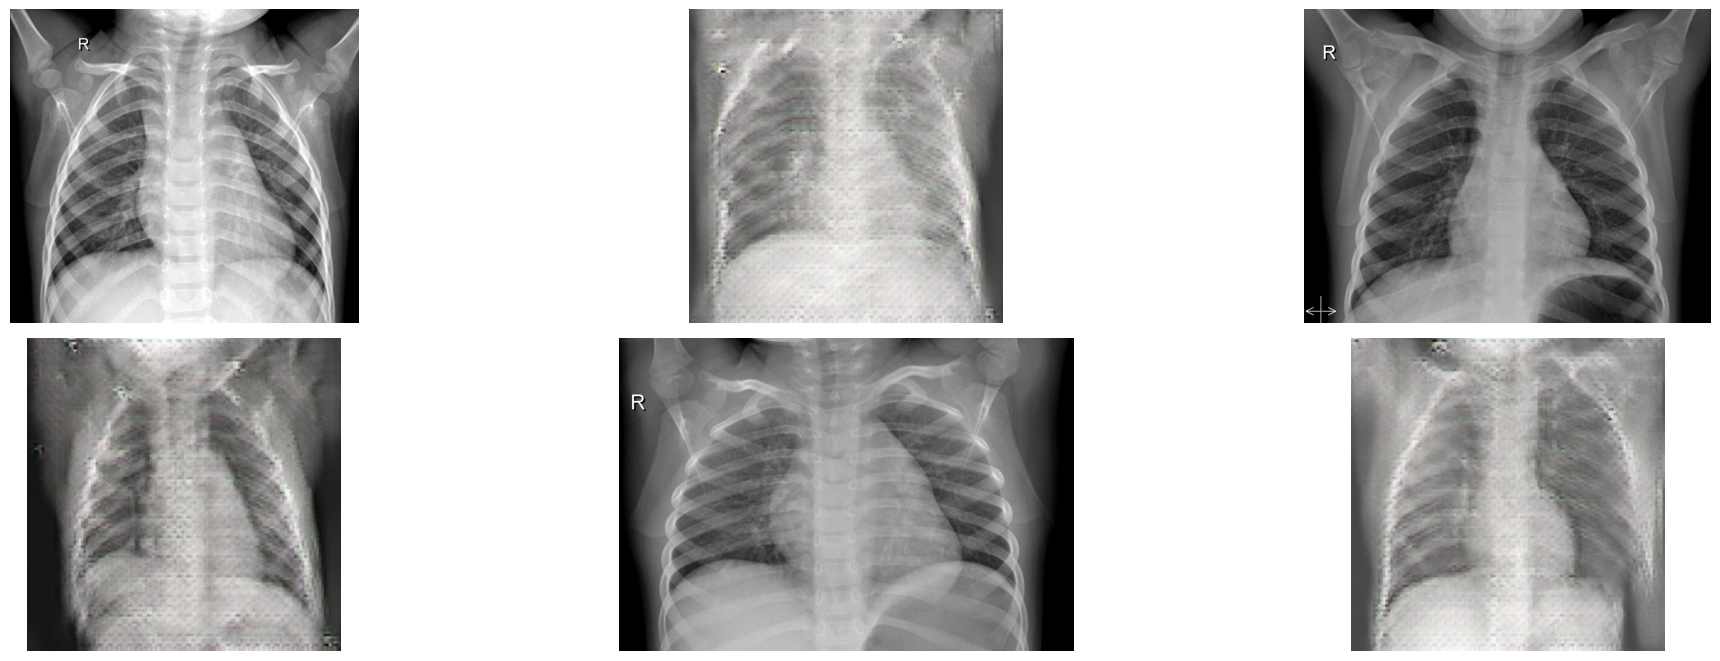

In [4]:
normal = os.listdir("/kaggle/input/test-xray-gen/chest_xray/train/NORMAL")
normal_dir = "/kaggle/input/test-xray-gen/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(6):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

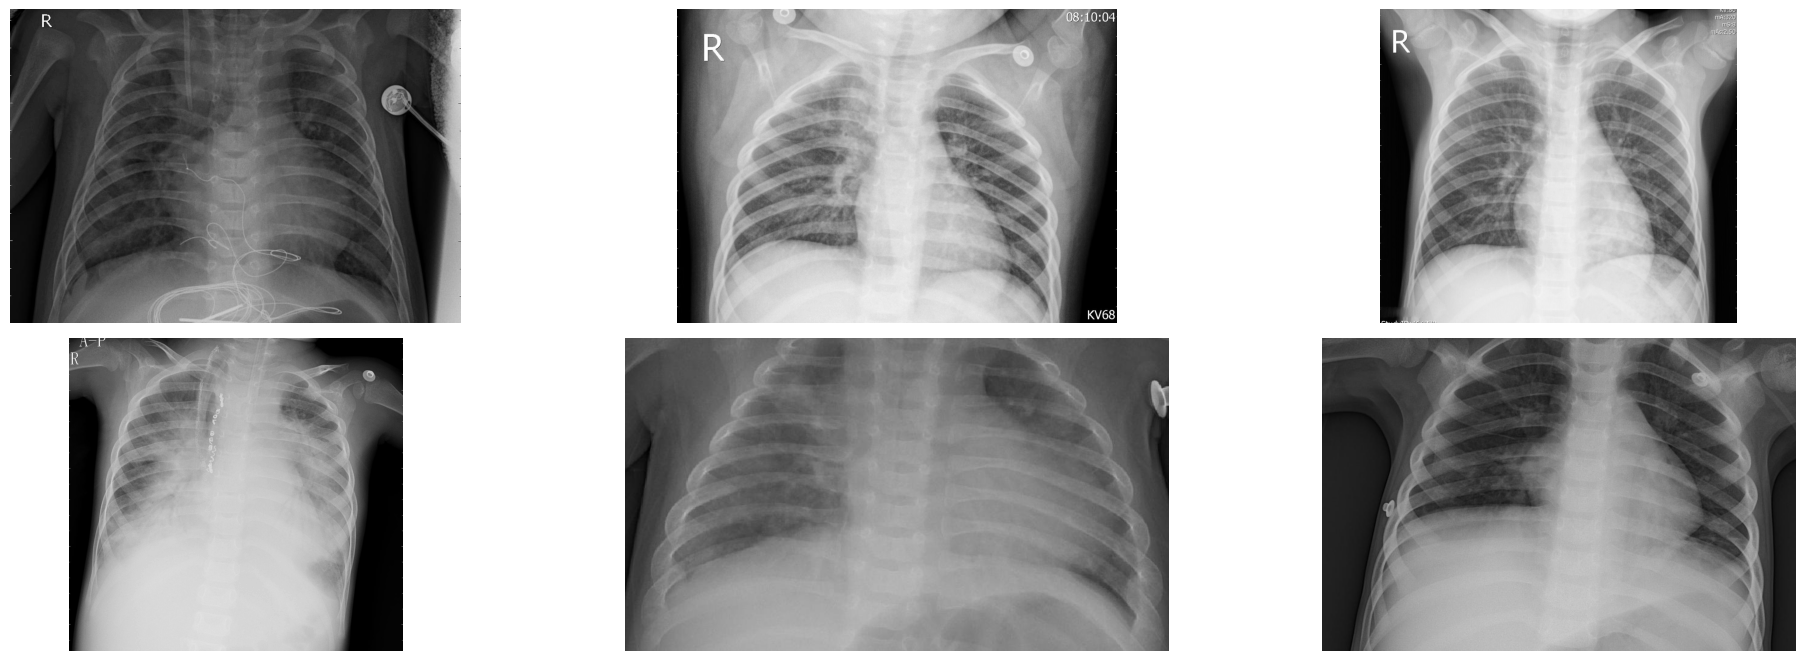

In [5]:
pneumonia = os.listdir("/kaggle/input/test-xray-gen/chest_xray/train/PNEUMONIA")
pneumonia_dir = "/kaggle/input/test-xray-gen/chest_xray/train/PNEUMONIA"
plt.figure(figsize=(20, 10))

for i in range(6):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]), )
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

The dimensions of the image are 1260 pixels width and 1400 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 137.2373 and the standard deviation is 66.7254


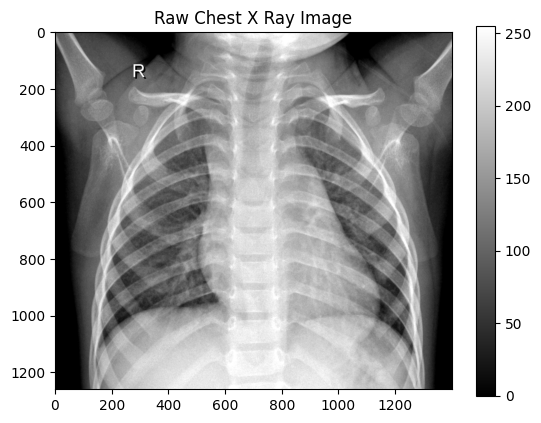

In [6]:
normal_img = os.listdir("/kaggle/input/test-xray-gen/chest_xray/train/NORMAL")[0]
normal_dir = "/kaggle/input/test-xray-gen/chest_xray/train/NORMAL"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

In [7]:
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 KB 12.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.9/771.9 KB 30.9 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [103]:
import keras_cv
from tensorflow.data import AUTOTUNE

image_size = 64
batch_size = 128 * strategy.num_replicas_in_sync
data_norm = keras.Sequential([
    layers.Rescaling(1./127.5, offset=-1)
])

augmenters = [
    keras_cv.layers.RandomCropAndResize(
        target_size=(image_size,image_size),
        crop_area_factor=(0.8, 1.0),
        aspect_ratio_factor=(0.9, 1.1),
    ),
    keras_cv.layers.RandomFlip(),
    keras_cv.layers.RandAugment(
        augmentations_per_image=3,
        magnitude=0.3,
        value_range=(0, 255))
]
data_augmentation = keras.Sequential(augmenters)

train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      seed=31,
      image_size=(image_size, image_size),
      label_mode='binary',
      validation_split=0.1,
      subset = 'training',
#       color_mode='grayscale',
      class_names=['NORMAL', 'PNEUMONIA'],
      batch_size=128)

val_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      seed=31,
      image_size=(image_size, image_size),
      label_mode='binary',
#       color_mode='grayscale',
      validation_split=0.1,
      subset = 'validation',
      class_names=['NORMAL', 'PNEUMONIA'],
      batch_size=128)

test_ds = tf.keras.utils.image_dataset_from_directory(
      test_dir,
      seed=31,
      image_size=(image_size, image_size),
      label_mode='binary',
#       crop_to_aspect_ratio = True,
#       color_mode='grayscale',
      shuffle=False,
      class_names=['NORMAL', 'PNEUMONIA'],
      batch_size=1)

train_ds = train_ds.map(lambda x,y: (data_augmentation(x),y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x,y: (data_norm(x),y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x,y: (data_norm(x),y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x,y: (data_norm(x),y), num_parallel_calls=AUTOTUNE)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 7750 files belonging to 2 classes.
Using 6975 files for training.
Found 7750 files belonging to 2 classes.
Using 775 files for validation.
Found 624 files belonging to 2 classes.


In [9]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [11]:
img = train_ds.take(1) #  (1,256,256,3)
plt.imshow(img.[0], cmap='gray')
plt.show()

TypeError: 'TakeDataset' object is not subscriptable

In [9]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

weight_for_0 = (1 / num_normal)*(num_normal + num_pneumonia)/2.0 
weight_for_1 = (1 / num_pneumonia)*(num_normal + num_pneumonia)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 1.00
Weight for class 1: 1.00


In [10]:
class ConvolutionalTokenizer(layers.Layer):
    """
    Creates Convolutional Tokens of images for feeding to Transformer Encoder.
    """
    def __init__(self,kernel_size=3,stride=1,padding=1,pooling_kernel_size=3,pooling_stride=2,conv_layers=2,num_output_channels=[64, 128, 256],**kwargs,):
        super(ConvolutionalTokenizer, self).__init__(**kwargs)

        # Creating a Sequential Keras Model for Tokenizing images
        self.conv_model = keras.Sequential()
        # Created the required number of convolutional layer
        for i in range(conv_layers):
            # Adding a conv2d layer with ReLU activation as suggested by authors
            self.conv_model.add(layers.Conv2D(num_output_channels[i],kernel_size,stride,padding="valid",use_bias=False,activation='relu',kernel_initializer="he_normal"))
#             self.conv_model.add(layers.BatchNormalization())
            # Zero Padding
            self.conv_model.add(layers.ZeroPadding2D(padding))
            # Pooling over the image with 3x3 kernel having padding='same' and stride=2
            self.conv_model.add(layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same"))
#         self.conv_model.add(layers.Dropout(0.2))

    def call(self, images):
        # Reshaping the outputs by flattening them
        outputs = self.conv_model(images)
        Flattened = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[3]),
        )
        return Flattened

    # Adding Learnable Positional Embeddings
    def pos_embeddings(self, image_size):
        inp = tf.ones((1, image_size, image_size, 3))
        out = self.call(inp)
        seq_len = tf.shape(out)[1]
        projection_dim = tf.shape(out)[-1]

        embed_layer = layers.Embedding(
            input_dim=seq_len, output_dim=projection_dim
        )
        return embed_layer, seq_len

In [11]:
def mlp(x, hidden_units, dropout):
    """
    Creates A Feed Forward Network`

    Args:
        hidden_units: Number of hidden units in MLP
        dropout: The Rate of dropout which is to be applied.
    """
    for units in hidden_units:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(dropout)(x)
    return x

In [12]:
class StochasticDepthRegularization(layers.Layer):
    def __init__(self, drop_rate, **kwargs):
        super(StochasticDepthRegularization, self).__init__(**kwargs)
        self.dr = drop_rate
    
    def call(self, x, training=None):
        if training:
            keep_rate = 1 - self.dr
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_rate + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_rate) * random_tensor
        return x

In [76]:
def Transformer_Encoder(L,embedded_patches,num_heads,projection_dim,transformer_units):
    """
    Transformer Encoder Block

    Args:
        L: number of transformer_layers

        embedded_patches: Patches from the Convolutional Tokenizer block

        num_heads: Number of Attention Heads

        projection_dim: Size of each attention head for query and key

        transformer_units: hidden units of MLP
    """


    # Iterating over the number of transformer layers
    for i in range(L):
        # Normalizing the input patches
        norm = layers.LayerNormalization(epsilon=1e-5)(embedded_patches)
        # Feeding to MHA
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm,norm)
        sdr1 = StochasticDepthRegularization(drop_rate=0.2,name=f'SDR_Lower_{i+1}')(attention_output)
        # Shortcut skip connection
        skip1 = layers.Add()([sdr1, embedded_patches])
        # Normalizing
        norm2= layers.LayerNormalization(epsilon=1e-5)(skip1)

        # Feed Forward MLP
        ffn = mlp(norm2, hidden_units=transformer_units, dropout=0.2)
        sdr2 = StochasticDepthRegularization(drop_rate=0.2,name=f"SDR_Top_{i+1}")(ffn)
        # Shortcut skip connection
        embedded_patches = layers.Add()([sdr2, skip1])

        return embedded_patches

In [77]:
def SeqPool(trans_enco_out):
    """
    Sequence Pooling block.

    Args:
        trans_enco_out: Takes in the Output of transformer encoder block

    Returns:
        A 1xD output to be fed to final classifier
    """
    # Normalizing the output of transformer enocder layer
    normalized = layers.LayerNormalization(epsilon=1e-5)(trans_enco_out)
    # Adding a linear layer
    linear=layers.Dense(1)(normalized)
    # Applying Softmax to the linear layer
    soft = tf.nn.softmax(linear, axis=1)
    # Multiplying the softmax of linear layer with the normalized output of orignal output of the transformer encoder block
    mult = tf.matmul(soft, normalized, transpose_a=True)
    # Squeezing the dimensions
    seq_pool_output = tf.squeeze(mult, -2)

    return seq_pool_output

In [79]:
def CompactConvolutionalTransformer(image_size=image_size,num_classes=2,input_shape=(image_size, image_size, 3),projection_dim=128,num_heads=2,L=1,transformer_units=[128,128]):
    """
    CCT model

    Args:
        image_size: size of image

        num_classes: Number of classes of output

        input_shape: shape of image

        projection_dim: Size of each attention head for query and key

        num_heads: Number of heads of MHA

        L: Number of transformer encoder layers

    Returns:
        CCT Model
    """

    inputs = layers.Input(input_shape)
    """
    Convolutional Tokenization Block
    """
    # Encode patches.
    conv_tokenizer = ConvolutionalTokenizer()
    embedded_patches = conv_tokenizer(inputs)

    # Adding positional embedding.
    pos_embed, seq_length = conv_tokenizer.pos_embeddings(image_size)
    positions = tf.range(start=0, limit=seq_length, delta=1)
    position_embeddings = pos_embed(positions)
    embedded_patches += position_embeddings


    """
    Transformer with Sequence Pooling Block
    """

    # Feeding embedded patches after adding embeddings to transformer encoder block
    embedded_patches=Transformer_Encoder(L,embedded_patches,num_heads=num_heads,projection_dim=projection_dim,transformer_units=transformer_units)

    # Applying sequence pooling to output of the transformer encoder block
    sequence_pooling=SeqPool(embedded_patches)

    # Adding a dense layer for predictions
    output= layers.Dense(num_classes,activation='softmax')(sequence_pooling)

    model = keras.Model(inputs=inputs, outputs=output)
    return model

In [80]:
CompactConvolutionalTransformer().summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 convolutional_tokenizer_17 (Co  (None, 256, 128)    75456       ['input_18[0][0]']               
 nvolutionalTokenizer)                                                                            
                                                                                                  
 tf.__operators__.add_17 (TFOpL  (None, 256, 128)    0           ['convolutional_tokenizer_17[0][0
 ambda)                                                          ]']                              
                                                                                           

In [81]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Create a MirroredStrategy.
# strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    # Instantiating our CCT model
    cct_model = CompactConvolutionalTransformer()
    # Compiling our Model
    cct_model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=0.001,weight_decay=0.0001),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
checkpoint_cb = ModelCheckpoint("xray_model.h5", save_best_only=True, verbose=1)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

# Training model for 50 epochs
history = cct_model.fit(
    train_ds,
#     class_weight={0:1.2,1:1.},
    epochs=100,
    callbacks=[early_stopping_cb],
    validation_data=val_ds
)

Number of devices: 8
Epoch 1/100


2023-05-24 22:19:04.667405: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AdamW/AssignAddVariableOp.
2023-05-24 22:19:04.910372: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AdamW/AssignAddVariableOp.


55/55 [==============================] - ETA: 0s - loss: 0.7850 - accuracy: 0.5123

2023-05-24 22:19:16.128800: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-24 22:19:16.250373: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


55/55 [==============================] - 23s 188ms/step - loss: 0.7850 - accuracy: 0.5123 - val_loss: 0.6898 - val_accuracy: 0.4890
Epoch 2/100
55/55 [==============================] - 2s 35ms/step - loss: 0.6852 - accuracy: 0.5601 - val_loss: 0.6655 - val_accuracy: 0.5471
Epoch 3/100
55/55 [==============================] - 2s 34ms/step - loss: 0.6535 - accuracy: 0.6146 - val_loss: 0.4966 - val_accuracy: 0.7897
Epoch 4/100
55/55 [==============================] - 2s 36ms/step - loss: 0.5734 - accuracy: 0.6995 - val_loss: 0.4539 - val_accuracy: 0.7961
Epoch 5/100
55/55 [==============================] - 2s 34ms/step - loss: 0.5316 - accuracy: 0.7273 - val_loss: 0.3703 - val_accuracy: 0.8503
Epoch 6/100
55/55 [==============================] - 2s 35ms/step - loss: 0.4981 - accuracy: 0.7507 - val_loss: 0.2940 - val_accuracy: 0.8852
Epoch 7/100
55/55 [==============================] - 2s 35ms/step - loss: 0.4835 - accuracy: 0.7606 - val_loss: 0.2805 - val_accuracy: 0.8890
Epoch 8/100
55/5

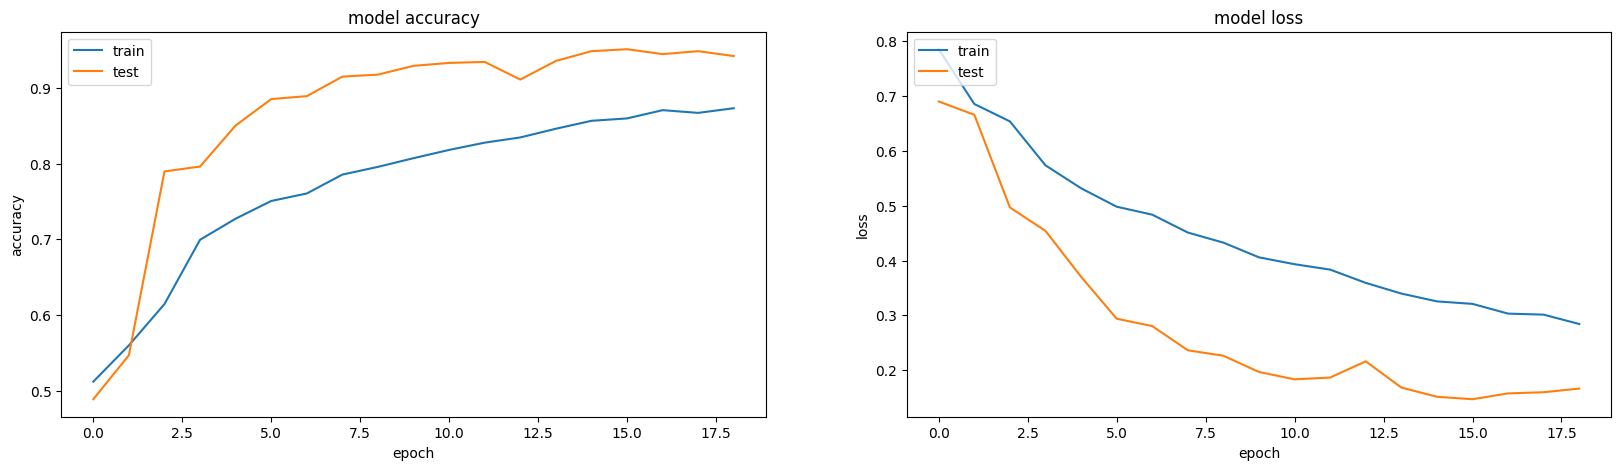

In [84]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [101]:
evaluation = cct_model.evaluate(test_ds)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = cct_model.evaluate(train_ds)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 7s 9ms/step - loss: 0.2754 - accuracy: 0.9006
Test Accuracy: 90.06%
55/55 [==============================] - 4s 12ms/step - loss: 0.2404 - accuracy: 0.9001
Train Accuracy: 90.01%


In [104]:
predicted_vals = cct_model.predict(test_ds)

624/624 [==============================] - 7s 9ms/step


In [105]:
predicted_categories = np.argmax(predicted_vals, axis = 1)

In [106]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

true_categories = tf.concat([y for x,y in test_ds], axis=0)
print(confusion_matrix(true_categories, predicted_categories))
pd.DataFrame(classification_report(true_categories, predicted_categories, output_dict=True))

[[185  49]
 [ 13 377]]


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.934343,0.884977,0.900641,0.909660,0.903489
recall,0.790598,0.966667,0.900641,0.878632,0.900641
f1-score,0.856481,0.924020,0.900641,0.890251,0.898693
support,234.000000,390.000000,0.900641,624.000000,624.000000
